# Emergent Topology of Ideas in Language

This short notebook shows how to compare the persistent homology of a text and some translation of it into a second language. This provides us with a way to augment loss functions using the Wasserstein or bottleneck distances between persistence diagrams. Hopefully this all proves useful for understanding the following:

Computing the persistent homology of ideas or linguistic objects and analyzing the topology of translated texts can *hopefully* provide valuable insights into the structure and relationships between different linguistic objects in a text. Here's why this approach is interesting and some potential applications:

1. **Uncovering hidden patterns**: Persistent homology can reveal hidden topological patterns in linguistic data, such as clusters or loops, that may not be apparent using traditional statistical methods. This can help identify relationships between words and concepts in the text and deepen our understanding of language structure.

2. **Comparative analysis**: By comparing the topology of linguistic objects in a source text and its translation, you can gain insights into how concepts and ideas change or remain invariant across languages. This could contribute to a better understanding of translation quality and the preservation of meaning in the translation process.

3. **Language modeling**: Persistent homology analysis could potentially be used to enhance language models by incorporating topological features into the model architecture or loss functions. This could lead to improved performance in tasks such as translation, summarization, or sentiment analysis.

4. **Studying language evolution**: Analyzing the persistent homology of different languages or historical texts can reveal information about the evolution of languages and how linguistic objects change or remain stable over time.

5. **Cross-linguistic studies**: Investigating topological similarities and differences across languages may help identify linguistic universals or language-specific phenomena, contributing to the field of comparative linguistics.

/Users/amelieschreiber/opt/anaconda3/lib/python3.9/site-packages/scipy/spatial/distance.py:1297: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)
usetex mode requires TeX.


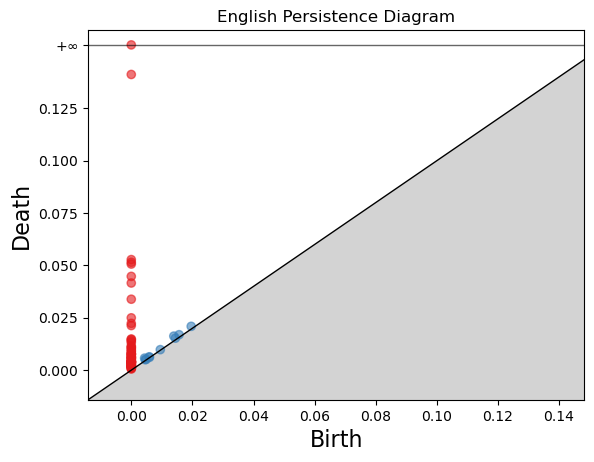

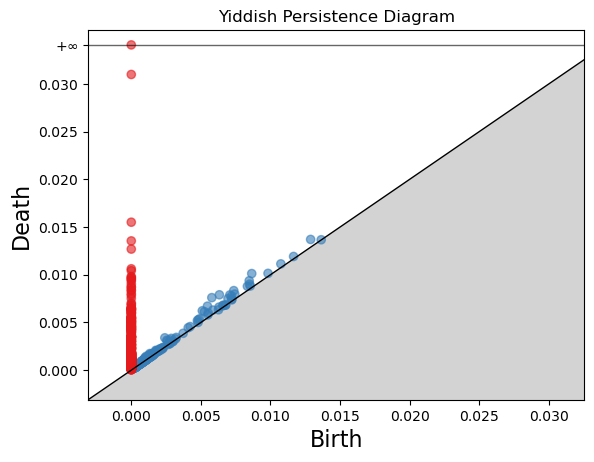

In [1]:
import numpy as np
import torch
import gudhi
import matplotlib.pyplot as plt
from gudhi import RipsComplex
from scipy.spatial.distance import jensenshannon
from sklearn.metrics import pairwise_distances
from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Config, AdamW

# Preprocess the text data
english_text = "Quantum computing and information theory"
yiddish_text = "קוואַנטום קאָמפּיוטינג און אינפֿאָרמאַציע טעאָריע"

# Load GPT-2 model and tokenizer
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
config = GPT2Config.from_pretrained(model_name)
config.output_attentions = True
model = GPT2LMHeadModel.from_pretrained(model_name, config=config)

# Calculate the distance matrix for a given text
def compute_distance_matrix(text):
    inputs = tokenizer(text, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    attention_matrix = outputs["attentions"][-1].squeeze().numpy()

    # Apply softmax to attention matrix
    softmax_attention_matrix = np.exp(attention_matrix) / np.sum(np.exp(attention_matrix), axis=-1, keepdims=True)

    # Reshape the softmax_attention_matrix
    reshaped_attention_matrix = softmax_attention_matrix.reshape(softmax_attention_matrix.shape[0] * softmax_attention_matrix.shape[1], -1)

    # Calculate Jensen-Shannon distance
    num_vectors = reshaped_attention_matrix.shape[0]
    js_distance_matrix = np.zeros((num_vectors, num_vectors))
    for i in range(num_vectors):
        for j in range(i + 1, num_vectors):
            js_distance = jensenshannon(reshaped_attention_matrix[i], reshaped_attention_matrix[j])
            js_distance_matrix[i, j] = js_distance
            js_distance_matrix[j, i] = js_distance

    return js_distance_matrix

# Compute the persistent homology using GUDHI
def compute_persistent_homology(distance_matrix):
    rips_complex = RipsComplex(distance_matrix=distance_matrix, max_edge_length=np.inf)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
    persistence = simplex_tree.persistence()
    return persistence

english_distance_matrix = compute_distance_matrix(english_text)
yiddish_distance_matrix = compute_distance_matrix(yiddish_text)

english_dgm = compute_persistent_homology(english_distance_matrix)
yiddish_dgm = compute_persistent_homology(yiddish_distance_matrix)

# Plot persistence diagrams
def plot_persistence_diagram(persistence, title):
    gudhi.plot_persistence_diagram(persistence)
    plt.title(title)
    plt.xlabel("Birth")
    plt.ylabel("Death")
    plt.show()

plot_persistence_diagram(english_dgm, "English Persistence Diagram")
plot_persistence_diagram(yiddish_dgm, "Yiddish Persistence Diagram")

#print("English persistence diagram:")
#print(english_dgm)

#print("Yiddish persistence diagram:")
#print(yiddish_dgm)

# Topological loss function (Bottleneck distance)
def topological_loss(persistence1, persistence2):
    bottleneck_distance = gudhi.bottleneck_distance(persistence1, persistence2)
    return bottleneck_distance